<h1>Introduction</h1>

<p>This notebook was inspired by an episode of the Joe Rogan podcast featuring Gad Saad. Gad claimed at one point in the episode to be curious about the length of a Yelp review vs. the amount of negativity in it (how few stars it got). He posits that the longer a review, the more likely it is to be a negative (low-star) review, so I thought I would try to put that hypothesis to the test.</p>

<p>To be clear, the initial hypothesis we are testing: <strong>There is an inverse correlation between the amount of stars that a Yelp score receives and the length of the review. If there is not a direct inverse correlation than an outlier of longer reviews for one-star reviews.</strong></p>

<h1>Contents</h1>

<ol>
    <li>Imports</li>
    <li>Initial Dataset Exploration</li>
    <li>Initial Hypothesis Testing</li>
    <li>Linear Regression/Probability Distribution Plotting</li>
    <li>Checking Random Reviews</li>
    <li>Wordclouds</li>
    <li>Searching for Specific Word Use</li>
    <li>Individual User Review Content</li>
</ol>

<h2>Imports</h2>

<p>Extremely basic set of imports here. the most important ones are gonna be pandas and seaborn. I'm sort of making this to get a bit more accustomed to data visualization with seaborn so I'll try to be using that a bit more frequently.</p>

In [600]:
# System defaults
import random

# Have to pip install
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Larger, more specific imports. Using wordcloud to create the wordclouds
# to represent the general tone of negative and positive tweets. Using 
# scikit-learn to create a linear regression and test correlations between
# number of stars and review length.
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [601]:
# The number of Yelp reviews we're going to import. tfw poor computer and 
# even poorer bank account to not be able to use a Spark instance.
import_rows = 800000

# Data gathered from Kaggle. 
#_____KAGGLE URL HERE_____#
df = pd.read_csv(
    'yelp_review.csv',
    nrows=import_rows,
)

<h2>Initial Dataset Exploration</h2>

<p>Just checking some random things for the dataset. Pandas provides a couple of functions that make this decently easy so we canjust sort of characterize the dataset for ourselves before we dive in.</p>

In [522]:
# Check out the basic structure of the dataset. Trying to see which columns have which datatype.
df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [523]:
# More explicit in our dataset setup reading.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 9 columns):
review_id      800000 non-null object
user_id        800000 non-null object
business_id    800000 non-null object
stars          800000 non-null int64
date           800000 non-null object
text           800000 non-null object
useful         800000 non-null int64
funny          800000 non-null int64
cool           800000 non-null int64
dtypes: int64(4), object(5)
memory usage: 54.9+ MB


In [524]:
# Basic stats. Aren't that useful for us now.
df.describe()

,stars,useful,funny,cool
count,800000.000000,800000.000000,800000.000000,800000.000000
mean,3.731506,1.332845,0.471001,0.546007
std,1.438039,4.283348,2.574510,2.389817
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,1456.000000,681.000000,245.000000


<h3>Initial Exploration Conclusions</h3>

<p>So the dataset's most important column is 'text'. This is where the actual text of each review is and we'll be able to use that to quantify word count in each review. Another interesting column type that I'd like to explore is userID. This would let us see if most of a user's reviews are positive, negative, or more neutral. I'm curious to see if certain useres are typically more likely to be mean in their reviews or more positive. Maybe we can make some fun wordclouds for individual users too, who knows.</p>

<p>For now we'll continue with the original hypothesis testing and see if there's any correlation between review length and positive/negative impression from the user.</p>

<h2>Initial Hypothesis Testing</h2>

<p>The goal of this section is two-fold. First to calculate the word count for every review and then to actually take some statistics for these reviews splitting between number of stars. The main hypothesis that we're testing is that as number of stars goes down, wordcount should increase, or otherwise one star reviews should represent the largest wordcount generally.</p>

In [525]:
# Word count should, in theory be the number of spaces in a sentence + 1.
# Example: This sentence has some spaces.
# Spaces: 4
# Word Count: 5 = 4 + 1
df['word_count'] = df['text'].str.count(' ') + 1

     
Of the 800000 total imported reviews:     
111828 reviews had 1 star.     
67017 reviews had 2 stars.    
91395 reviews had 3 stars.    
183642 reviews had 4 stars.    
346118 reviews had 5 stars.



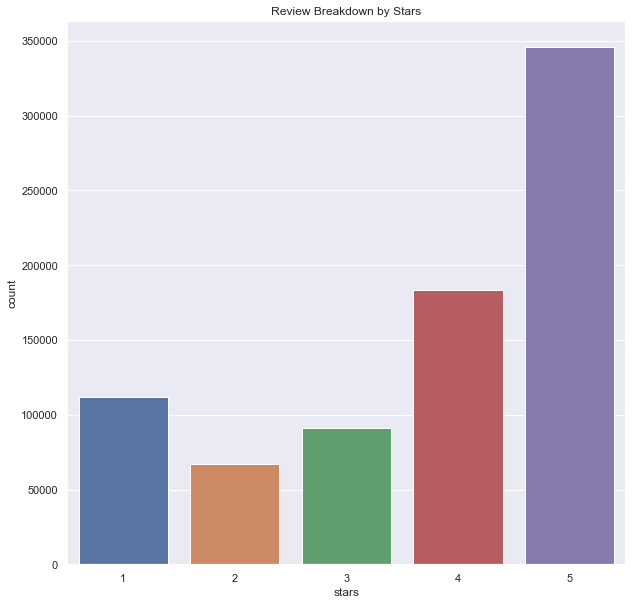

In [526]:
# Create a count of each rating. The goal here is to get a barchart that shows
# the amount of each star given in the whole dataset. This will generally let us
# quantify if most reviews on Yelp are positive, negative, or neutral.
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(df['stars']).set_title('Review Breakdown by Stars')
total_reviews = import_rows

# Here we split the dataframe with a conditional. The result will be 
# having a dataframe for each star. So we should get 5 dataframes,
# each containing all reviews with a given star rating.
one_star = df[df.stars == 1].reset_index()
one_star_count = len(one_star)

two_star = df[df['stars'] == 2].reset_index()
two_star_count = len(two_star)

three_star =  df[df['stars'] == 3].reset_index()
three_star_count = len(three_star)

four_star = df[df['stars'] == 4].reset_index()
four_star_count = len(four_star)

five_star = df[df['stars'] == 5].reset_index()
five_star_count = len(five_star)

# Basic quantification to see how many of each are being shown in the bar chart.
print(' \
    \nOf the %d total imported reviews: \
    \n%d reviews had 1 star. \
    \n%d reviews had 2 stars.\
    \n%d reviews had 3 stars.\
    \n%d reviews had 4 stars.\
    \n%d reviews had 5 stars.\n' \
    % (total_reviews, one_star_count, two_star_count, three_star_count, four_star_count, five_star_count))

<p>Very interesting! So wordcount notwithstanding, we see that a vast vast majority of the reviews on Yelp are 5 stars. Almost deviantly so! We'll try to control for this increase in size later, but for now that sort of goes against the general philosophy of Gad's hypothesis because from this initial view, it seems that people typically are most likely hopping on Yelp to give a positive review!</p>

<p>The next step is to take some descriptive statistics for each star review. We'll see if, on average, the word count for a given starred review is longer or shorter.</p>

In [564]:
star_dfs = [one_star, two_star, three_star, four_star, five_star]

medians = [x['word_count'].median() for x in star_dfs]
print('The median amount of words in a one star review was %d' % (medians[0]))
print('The median amount of words in a two star review was %d' % (medians[1]))
print('The median amount of words in a three star review was %d' % (medians[2]))
print('The median amount of words in a four star review was %d' % (medians[3]))
print('The median amount of words in a five star review was %d' % (medians[4]))

means = [x['word_count'].mean() for x in star_dfs]
print('\nThe mean amount of words in a one star review was %.2f' % (means[0]))
print('The mean amount of words in a two star review was %.2f' % (means[1]))
print('The mean amount of words in a three star review was %.2f' % (means[2]))
print('The mean amount of words in a four star review was %.2f' % (means[3]))
print('The mean amount of words in a five star review was %.2f' % (means[4]))

maxes = [x['word_count'].max() for x in star_dfs]
print('\nThe largest amount of words in a one star review was %d' % (maxes[0]))
print('The largest amount of words in a two star review was %d' % (maxes[1]))
print('The largest amount of words in a three star review was %d' % (maxes[2]))
print('The largest amount of words in a four star review was %d' % (maxes[3]))
print('The largest amount of words in a five star review was %d' % (maxes[4]))

stdevs = [x['word_count'].std() for x in star_dfs]
print('\nThe standard deviation of words in a one star review was %.2f' % (stdevs[0]))
print('The standard deviation of words in a two star review was %.2f' % (stdevs[1]))
print('The standard deviation of words in a three star review was %.2f' % (stdevs[2]))
print('The standard deviation of words in a four star review was %.2f' % (stdevs[3]))
print('The standard deviation of words in a five star review was %.2f' % (stdevs[4]))

long_review_min = 200

long_one_star = one_star[one_star['word_count'] > long_review_min]
long_two_star = two_star[two_star['word_count'] > long_review_min]
long_three_star = three_star[three_star['word_count'] > long_review_min]
long_four_star = four_star[four_star['word_count'] > long_review_min]
long_five_star = five_star[five_star['word_count'] > long_review_min]

long_star_dfs = [long_one_star, long_two_star, long_three_star, long_four_star, long_five_star]
counts = [one_star_count, two_star_count, three_star_count, four_star_count, five_star_count]

percentages_long = [float(len(long_star_dfs[x]))/float(counts[x])*100 for x in range(0,len(long_star_dfs))]

outlier_review_min = 800

outlier_one_star = one_star[one_star['word_count'] > outlier_review_min]
outlier_two_star = two_star[two_star['word_count'] > outlier_review_min]
outlier_three_star = three_star[three_star['word_count'] > outlier_review_min]
outlier_four_star = four_star[four_star['word_count'] > outlier_review_min]
outlier_five_star = five_star[five_star['word_count'] > outlier_review_min]

outlier_star_dfs = [outlier_one_star, outlier_two_star, outlier_three_star, outlier_four_star, outlier_five_star]

percentages_outlier = [float(len(outlier_star_dfs[x]))/float(counts[x])*100 for x in range(0,len(outlier_star_dfs))]

print('\nThe percent of one star reviews with over %d words was %.2f percent' % (long_review_min, percentages_long[0]))
print('The percent of two star reviews with over %d words was %.2f percent' % (long_review_min, percentages_long[1]))
print('The percent of three star reviews with over %d words was %.2f percent' % (long_review_min, percentages_long[2]))
print('The percent of four star reviews with over %d words was %.2f percent' % (long_review_min, percentages_long[3]))
print('The percent of five star reviews with over %d words was %.2f percent' % (long_review_min, percentages_long[4]))

print('\nThe percent of one star reviews with over %s words was %.2f percent' % (outlier_review_min, percentages_outlier[0]))
print('The percent of two star reviews with over %d words was %.2f percent' % (outlier_review_min, percentages_outlier[1]))
print('The percent of three star reviews with over %d words was %.2f percent' % (outlier_review_min, percentages_outlier[2]))
print('The percent of four star reviews with over %d words was %.2f percent' % (outlier_review_min, percentages_outlier[3]))
print('The percent of five star reviews with over %d words was %.2f percent' % (outlier_review_min, percentages_outlier[4]))

The median amount of words in a one star review was 104
The median amount of words in a two star review was 108
The median amount of words in a three star review was 102
The median amount of words in a four star review was 86
The median amount of words in a five star review was 65

The mean amount of words in a one star review was 146.28
The mean amount of words in a two star review was 144.08
The mean amount of words in a three star review was 134.11
The mean amount of words in a four star review was 116.57
The mean amount of words in a five star review was 91.18

The largest amount of words in a one star review was 1065
The largest amount of words in a two star review was 1662
The largest amount of words in a three star review was 1006
The largest amount of words in a four star review was 1580
The largest amount of words in a five star review was 1118

The standard deviation of words in a one star review was 136.27
The standard deviation of words in a two star review was 124.14
The s

<h3>Some Intermediate Conclusions</h3>

<p>It looks like there's some interesting correlation showing up here. Starting with median, we see what appears to be a generally negative trend. It appears that the median amount of words decreases as people like a service more and more which holds with Gad's hypothesis on the show. The same holds for the mean values.</p>

<p>Interestingly enough, the longest reviews by a max value are some of the higher star reviews, but these may be outliers and not general approximations since max is highly succeptible to outliers.</p>

<p>What I thought was more interesting were the last two readouts here. With the standard deviation we see a negative correlation meaning that as you increase the amount of stars for a review, the volatility of the length of the review goes down. This means that if you give a one star review on Yelp you're going to either leave a novel of a rant, or a simple three word phrase.</p>

<p>Possibly the most interesting results are at the end. We've found a correlation in the portion of a given star's reviews that are negative. Over half of all reviews 3 stars and below are over 100 words! That's an insane correlation. Especially when you consider that only 30 percent of five star reviews are over 100 words. Even though far more reviews have 5 stars than any other rating, the percentage of the lower reviews that are wordier are demonstrably higher!</p>

<h2>Linear Regression</h2>

<p>So we found some interesting correlations between the word counts of yelp reviews and how positive or negative they were. Here we need to actually quantify that correlation and see if we're able to prove without a shadow of a doubt that decreasing the amount of stars tends to increase the likelihood that a reviewer will leave a long review.</p>

Mean squared error: 2.12 words
r2 Value: 0.99


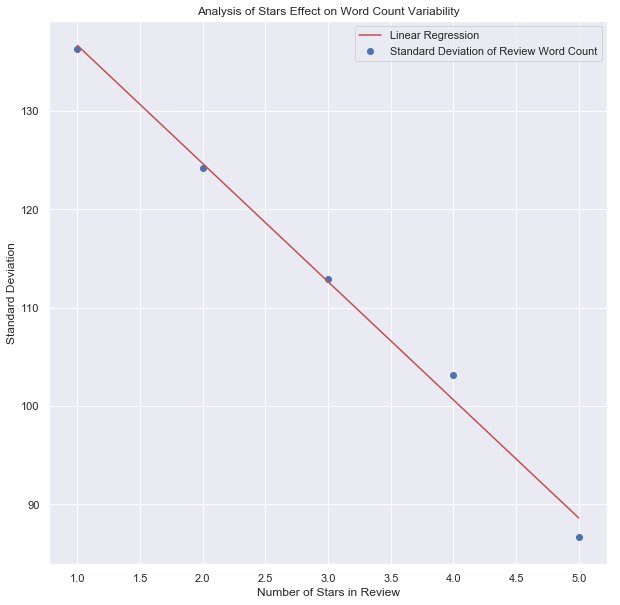

In [567]:
fig, ax = plt.subplots(figsize=(10,10))

x_values = np.array([(x+1, x+1) for x, val in enumerate(stdevs)])
stdevs_Y = np.array([(x+1, val) for x,val in enumerate(stdevs)])

regr = linear_model.LinearRegression()
regr.fit(x_values, stdevs_Y)

x_list = range(1,len(actual)+1)
predicted = regr.predict(x_values)
predicted = [x[1] for x in predicted]
actual = [x[1] for x in stdevs_Y]

plt.plot(x_list, predicted, 'r-')
plt.scatter(x_list, actual)

plt.xlabel('Number of Stars in Review')
plt.ylabel('Standard Deviation')
plt.title('Analysis of Stars Effect on Word Count Variability')
plt.legend([ 'Linear Regression', 'Standard Deviation of Review Word Count'])

print("Mean squared error: %.2f words" % mean_squared_error(actual, predicted))
print('r2 Value: %.2f' % r2_score(actual, predicted))

Mean squared error: 41.60 words
r2 Value: 0.90


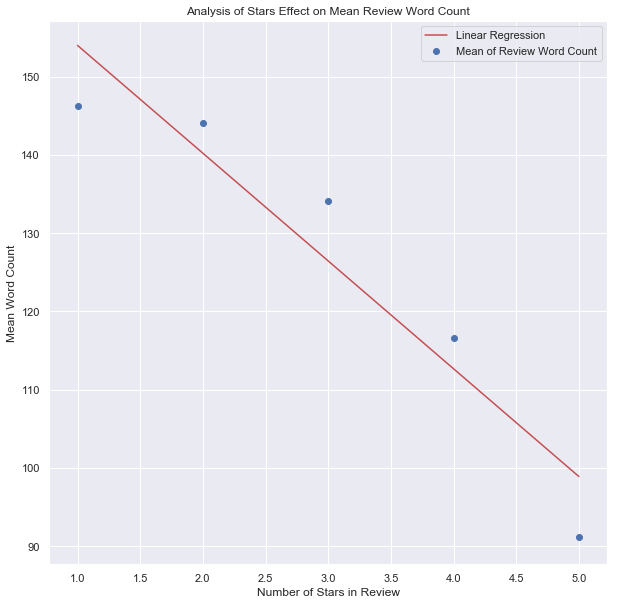

In [568]:
fig, ax = plt.subplots(figsize=(10,10))

x_values = np.array([(x+1, x+1) for x, val in enumerate(means)])
means_Y = np.array([(x+1, val) for x,val in enumerate(means)])

regr = linear_model.LinearRegression()
regr.fit(x_values, means_Y)

x_list = range(1,len(actual)+1)
predicted = regr.predict(x_values)
predicted = [x[1] for x in predicted]
actual = [x[1] for x in means_Y]

plt.plot(x_list, predicted, 'r-')
plt.scatter(x_list, actual)

plt.xlabel('Number of Stars in Review')
plt.ylabel('Mean Word Count')
plt.title('Analysis of Stars Effect on Mean Review Word Count')
plt.legend([ 'Linear Regression', 'Mean of Review Word Count'])

print("Mean squared error: %.2f words" % mean_squared_error(actual, predicted))
print('r2 Value: %.2f' % r2_score(actual, predicted))

Mean squared error: 52.00 words
r2 Value: 0.79


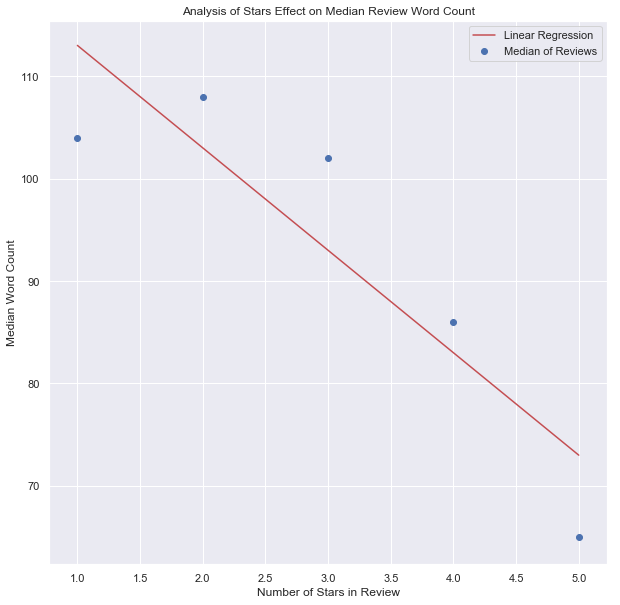

In [569]:
fig, ax = plt.subplots(figsize=(10,10))

x_values = np.array([(x+1, x+1) for x, val in enumerate(medians)])
medians_Y = np.array([(x+1, val) for x,val in enumerate(medians)])

regr = linear_model.LinearRegression()
regr.fit(x_values, medians_Y)

x_list = range(1,len(actual)+1)
predicted = regr.predict(x_values)
predicted = [x[1] for x in predicted]
actual = [x[1] for x in medians_Y]

plt.plot(x_list, predicted, 'r-')
plt.scatter(x_list, actual)

plt.xlabel('Number of Stars in Review')
plt.ylabel('Median Word Count')
plt.title('Analysis of Stars Effect on Median Review Word Count')
plt.legend([ 'Linear Regression', 'Median of Reviews'])

print("Mean squared error: %.2f words" % mean_squared_error(actual, predicted))
print('r2 Value: %.2f' % r2_score(actual, predicted))

Mean squared error: 2.84 words
r2 Value: 0.89


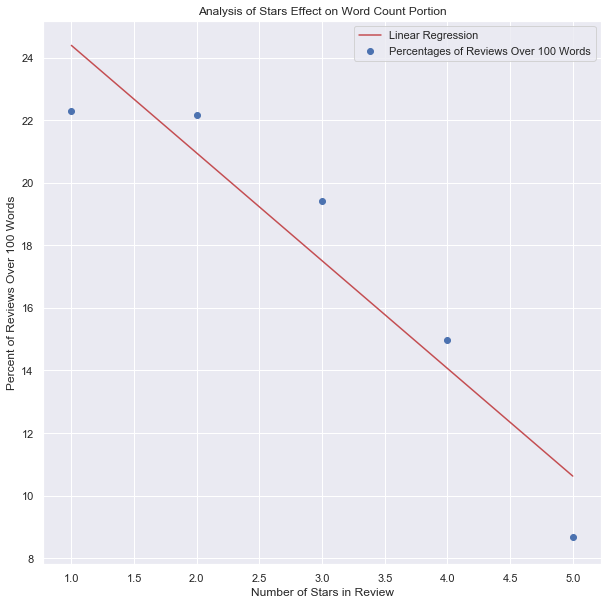

In [570]:
fig, ax = plt.subplots(figsize=(10,10))

x_values = np.array([(x+1, x+1) for x, val in enumerate(percentages_long)])
percentages_Y = np.array([(x+1, val) for x,val in enumerate(percentages_long)])

regr = linear_model.LinearRegression()
regr.fit(x_values, percentages_Y)

x_list = range(1,len(actual)+1)
predicted = regr.predict(x_values)
predicted = [x[1] for x in predicted]
actual = [x[1] for x in percentages_Y]

plt.plot(x_list, predicted, 'r-')
plt.scatter(x_list, actual)

plt.xlabel('Number of Stars in Review')
plt.ylabel('Percent of Reviews Over 100 Words')
plt.title('Analysis of Stars Effect on Word Count Portion')
plt.legend([ 'Linear Regression', 'Percentages of Reviews Over 100 Words'])

print("Mean squared error: %.2f words" % mean_squared_error(actual, predicted))
print('r2 Value: %.2f' % r2_score(actual, predicted))

Mean squared error: 0.003 words
r2 Value: 0.91


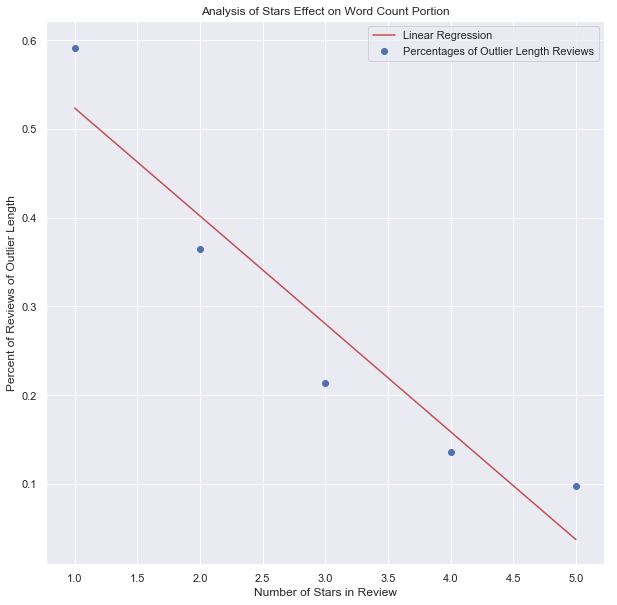

In [574]:
fig, ax = plt.subplots(figsize=(10,10))

x_values = np.array([(x+1, x+1) for x, val in enumerate(percentages_outlier)])
outlier_percentages_Y = np.array([(x+1, val) for x,val in enumerate(percentages_outlier)])

regr = linear_model.LinearRegression()
regr.fit(x_values, outlier_percentages_Y)

x_list = range(1,len(actual)+1)
predicted = regr.predict(x_values)
predicted = [x[1] for x in predicted]
actual = [x[1] for x in outlier_percentages_Y]

plt.plot(x_list, predicted, 'r-')
plt.scatter(x_list, actual)

plt.xlabel('Number of Stars in Review')
plt.ylabel('Percent of Reviews of Outlier Length')
plt.title('Analysis of Stars Effect on Word Count Portion')
plt.legend(['Linear Regression', 'Percentages of Outlier Length Reviews'])

print("Mean squared error: %.3f words" % mean_squared_error(actual, predicted))
print('r2 Value: %.2f' % r2_score(actual, predicted))

<h2>Probability Distribution Plotting</h2>

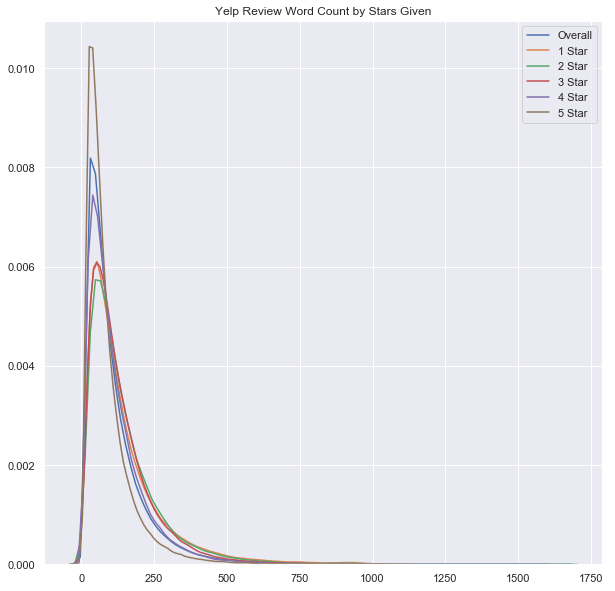

In [554]:
fig, ax = plt.subplots(figsize=(10,10))

overall_plot = sns.kdeplot(df['word_count']).set_title('Yelp Review Word Count by Stars Given')
one_star_plot = sns.kdeplot(one_star['word_count'], ax=ax)
two_star_plot = sns.kdeplot(two_star['word_count'], ax=ax)
three_star_plot = sns.kdeplot(three_star['word_count'], ax=ax)
four_star_plot = sns.kdeplot(four_star['word_count'], ax=ax)
five_star_plot = sns.kdeplot(five_star['word_count'], ax=ax)

plt.legend(['Overall','1 Star','2 Star','3 Star','4 Star','5 Star'])

<p>So naturally we see the distribution a bit wider for the lower star reviews from that volatility that we mentioned previously. Let's satisfy my curiosity and do the same exact process for all reviews over 200 words.</p>

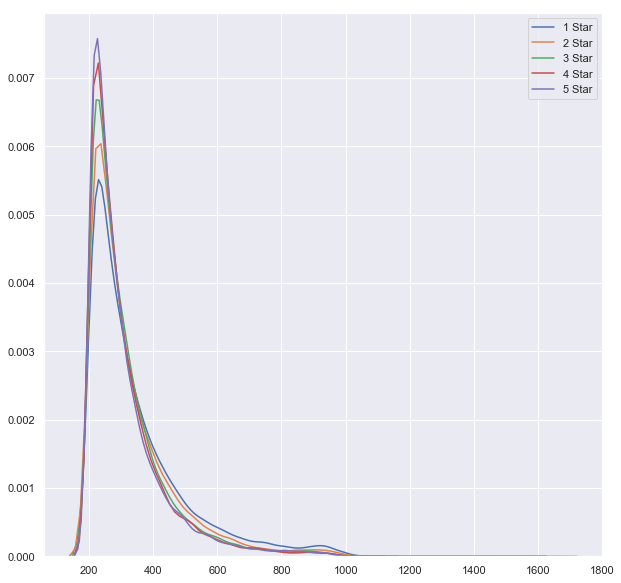

In [559]:
fig, ax = plt.subplots(figsize=(10,10))

long_one_star_plot = sns.kdeplot(long_one_star['word_count'], ax=ax)
long_two_star_plot = sns.kdeplot(long_two_star['word_count'], ax=ax)
long_three_star_plot = sns.kdeplot(long_three_star['word_count'], ax=ax)
long_four_star_plot = sns.kdeplot(long_four_star['word_count'], ax=ax)
long_five_star_plot = sns.kdeplot(long_five_star['word_count'], ax=ax)

plt.legend(['1 Star','2 Star','3 Star','4 Star','5 Star'])

<p>I smell some interesting outliers. Let's get a probability density function for all reviews over 800 words. In theory, that's where thre real salt would lie.</p>

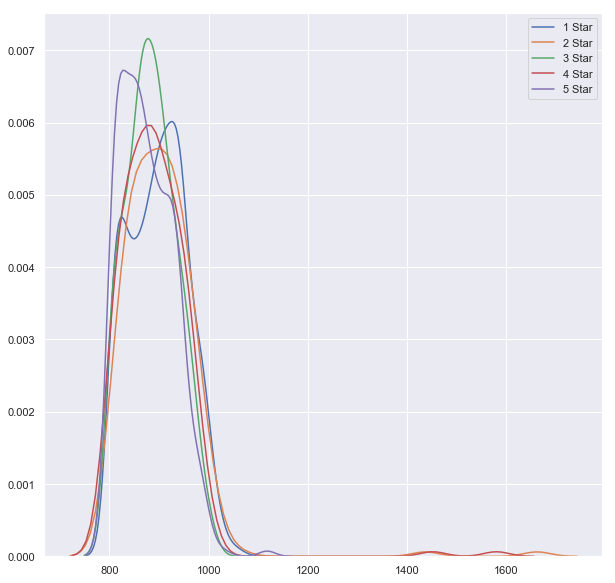

In [560]:
fig, ax = plt.subplots(figsize=(10,10))

outlier_one_star_plot = sns.kdeplot(outlier_one_star['word_count'], ax=ax)
outlier_two_star_plot = sns.kdeplot(outlier_two_star['word_count'], ax=ax)
outlier_three_star_plot = sns.kdeplot(outlier_three_star['word_count'], ax=ax)
outlier_four_star_plot = sns.kdeplot(outlier_four_star['word_count'], ax=ax)
outlier_five_star_plot = sns.kdeplot(outlier_five_star['word_count'], ax=ax)

plt.legend(['1 Star','2 Star','3 Star','4 Star','5 Star'])

<h2>Checking Random Reviews</h2>

In [504]:
print('Random 1 Star Review: \n')
one_star['text'][random.randint(1,one_star_count)]

Random 1 Star Review: 



'Biggest bunch of liars I\'ve dealt with in a long time. "Go ahead and take the car and call in for an appointment and we\'ll fix the scratches". Made an appointment (after I drove it off the lot) and was then told "oh no, that is too deep of a scratch. You\'ll have to take it to a body shop to get it repaired at your expense". I have not yet put 1000 miles on the car and the sound system sounds like a loose speaker wire. Took it in and was told by the service manager that it would be a "$130.00 diagnostic fee" for them to even look at it. While buying the car I told them repeatedly that I did not want their car theft, leather and paint protectant plans. They added them to the price of the car anyway for $1800.00. When I said no they said they\'d have to start all over with the negotiations of the price and they ended up charging me anyway. No information about extended warranty-said they couldn\'t provide me with that. I should have walked away from the deal but wanted the car. Should

In [505]:
print('Random 2 Star Review: \n')
two_star['text'][random.randint(1,two_star_count)]

Random 2 Star Review: 



'I\'m a member of OTF in San Diego. I am visiting for the holiday and wanted to get a workout in. I was so surprised at how unfriendly\\/unhelpful this staff was as opposed to my home studio! They acted annoyed when I told them I had an injury and just wanted to let them know because my studio always asks if anyone needs adjustments before we begin. The instructor, Jamie, left me to do my own workout the last 15 mins as opposed to helping me with other options. Then, I let her know that my heart monitor wasn\'t working and she just said, "Oh, I guess we will need to fix that." And never followed up. My gym in San Diego is super involved and friendly and make everyone feel like they are family. No one seemed engaged and everyone seemed annoyed to be there, working. I won\'t come back here.'

In [506]:
print('Random 3 Star Review: \n')
three_star['text'][random.randint(1,three_star_count)]

Random 3 Star Review: 



"Let's cut to the chase, food is decent - okay, but nothing to run back to. \n\nThe nutella shake $6.50 is really tasty and the Gouda Mac & Cheese Bites $6.50 were good for a fried carb filled appetizer. The County Line Fried Chicken Sandwich $9.75 is pretty big, but lacking flavor. It was good after I added pepper jack cheese, extra coleslaw (they give you a micro portion), hot sauce, and some guac I had at home. \n\nI placed an in-person take-out order with the hostess who was very personable and friendly. The décor is clean and hip, and there is plenty of parking since this place is on the outside of a mall. The food isn't bad, but I've only made it here twice in the two years I've lived on the west side if that tells you anything.\n\n\n\n\nUPDATE**\nCustomer service at The Rail is outstanding! They really care about how your experience was and genuinely listen when you offer suggestions. I tried them out again, this time for a Local Yokel Burger (added avocado) and a side of their 

In [507]:
print('Random 4 Star Review: \n')
four_star['text'][random.randint(1,four_star_count)]

Random 4 Star Review: 



'Excellent copy services,cheap scans,alot of staff to help on the floor.and they have trail mix.plus its across the street from my work,sign up for the staples reward cards,it actually helps and save me alot,stay classy yelpers'

In [508]:
print('Random 5 Star Review: \n')
five_star['text'][random.randint(1,five_star_count)]

Random 5 Star Review: 



"Best Korean restaurant in town. Skip going all the way to Chinatown for a good Korean meal. This place is wonderful. Lunch buffet is great. All food is kept in the back until you ask for what you want which is great because there's no tampering with other people's food and most buffets have food sitting out for long periods of time. We tried the regular pork belly, smoked garlic pork belly, steak bulgolgi, and the beef brisket. By far the winners were smoked pork belly and steak bulgolgi. Seong was our server...great service! Prices are excellent and the food is way better than Korean restaurants in Chinatown."

In [509]:
print('Random Long 1 Star Review: \n')
long_df = one_star[one_star['word_count'] > 100].reset_index()
long_df['text'][random.randint(1,len(long_df))]

Random Long 1 Star Review: 



'Wow, was I unimpressed with this restaurant. We had a party of 6, 4 of which were very disappointed with the meal. A plain ceasar salad was $16. I had the IL Manzo (Filet Tenderloin). It was more expensive than a Kobe steak I got at Wolfgang Puck restaurant two days earlier. And the quality? Well, terrible is what comes to mind. The servers took a long time just to bring us water and was very unprofessional. \n\nWe were also told that we would get a window seat - or something near the window, and they never sat us there. \n\nI ordered a simple ceasar salad, a glass of wine, and a poorly cooked steak for $90.\n\nSave your money, go to Wolfgang Puck at MGM. Check out the fountains from the strip, they are just as amazing.'

In [510]:
print('Random Short 1 Star Review: \n')
short_df = one_star[one_star['word_count'] < 10].reset_index()
short_df['text'][random.randint(1,len(short_df))]

Random Short 1 Star Review: 



"Gross place, not attractive girls. Wouldn't visit again."

In [511]:
print('Random Funny and Short 1 Star Review: \n')
funny_short_df = one_star[one_star['word_count'] < 10].reset_index(drop=True)
funny_short_df = funny_short_df[funny_short_df['funny'] == 1].reset_index(drop=True)
funny_short_df['text'][random.randint(1,len(funny_short_df))]

Random Funny and Short 1 Star Review: 



'Generic-fill-you-up-on-the-cheapest-bulk-ingradients-we-can-find-in-the-clearance-section-of food-city-kinda-of-meal.'

In [512]:
print('Random Funny and Long 1 Star Review: \n')
funny_long_df = one_star[one_star['word_count'] > 100].reset_index(drop=True)
funny_long_df = funny_long_df[funny_long_df['funny'] == 1].reset_index(drop=True)
funny_long_df['text'][random.randint(1,len(funny_long_df))]

Random Funny and Long 1 Star Review: 



"Wish I could give 0 stars. I had been going there for years and it is nothing fancy but was a good place to go for an inexpensive cut. I never got anything fancy so I can't speak to that. However, today was the 3rd time this calendar year that I tried to go there after work and they felt a need to closer early.  I am fortunate enough to have a job and just can't be there between 10 & 4...\nHere's an idea: stop claiming you are a family salon. Stop advertising hours you don't intend on being open. Just be a place for retirees or whatever.  I know I won't waste my time heading there anytime"

<h2>Wordclouds</h2>

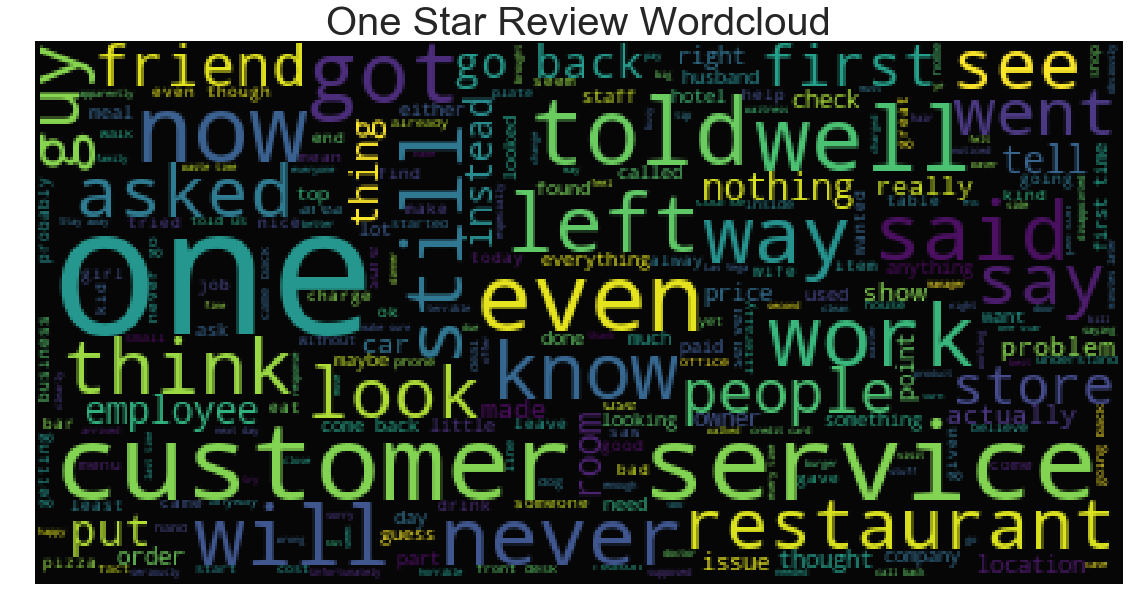

In [513]:
clean_mask = np.array(Image.open('Yelp.png'))
clean_mask = clean_mask[:,:,1]

text = one_star['text'].values

wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("One Star Review Wordcloud", fontsize=40)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

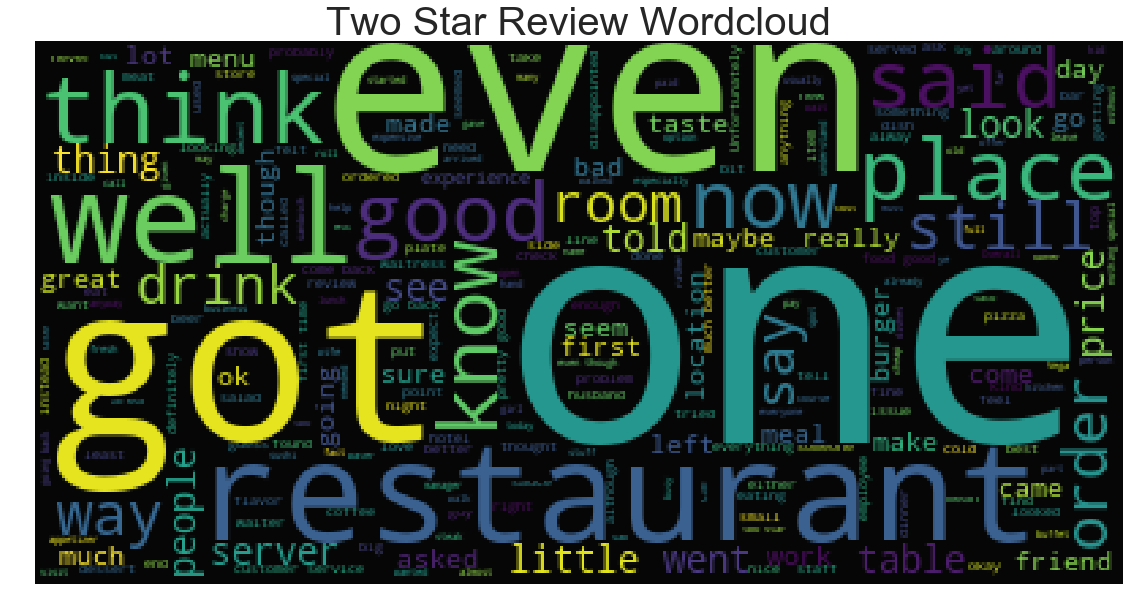

In [514]:
clean_mask = np.array(Image.open('Yelp.png'))
clean_mask = clean_mask[:,:,1]

text = two_star['text'].values

wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Two Star Review Wordcloud", fontsize=40)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

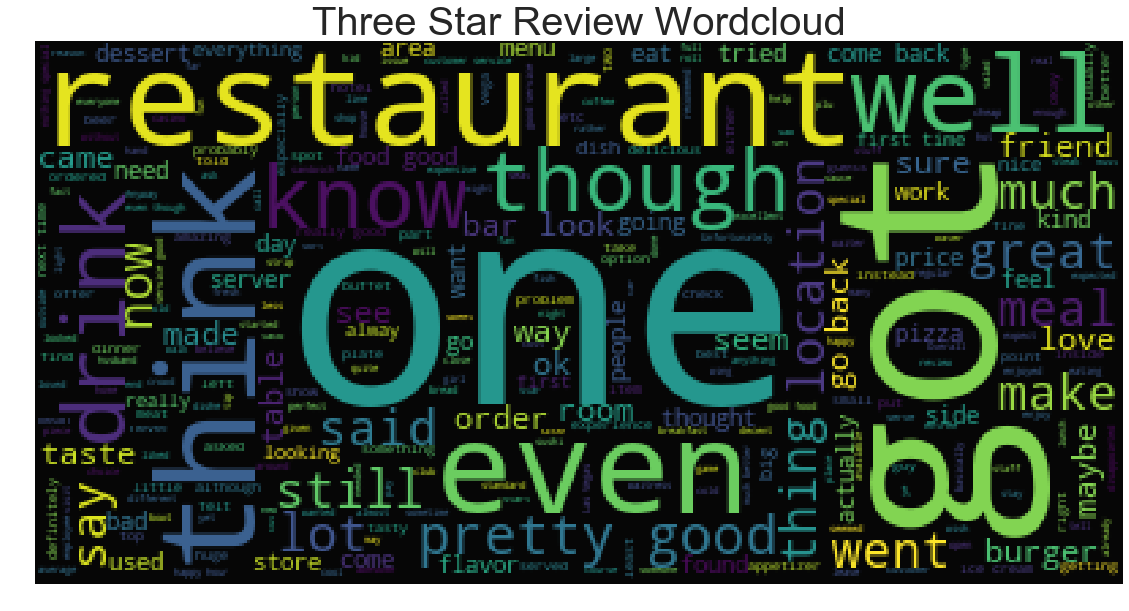

In [515]:
clean_mask = np.array(Image.open('Yelp.png'))
clean_mask = clean_mask[:,:,1]

text = three_star['text'].values

wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Three Star Review Wordcloud", fontsize=40)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

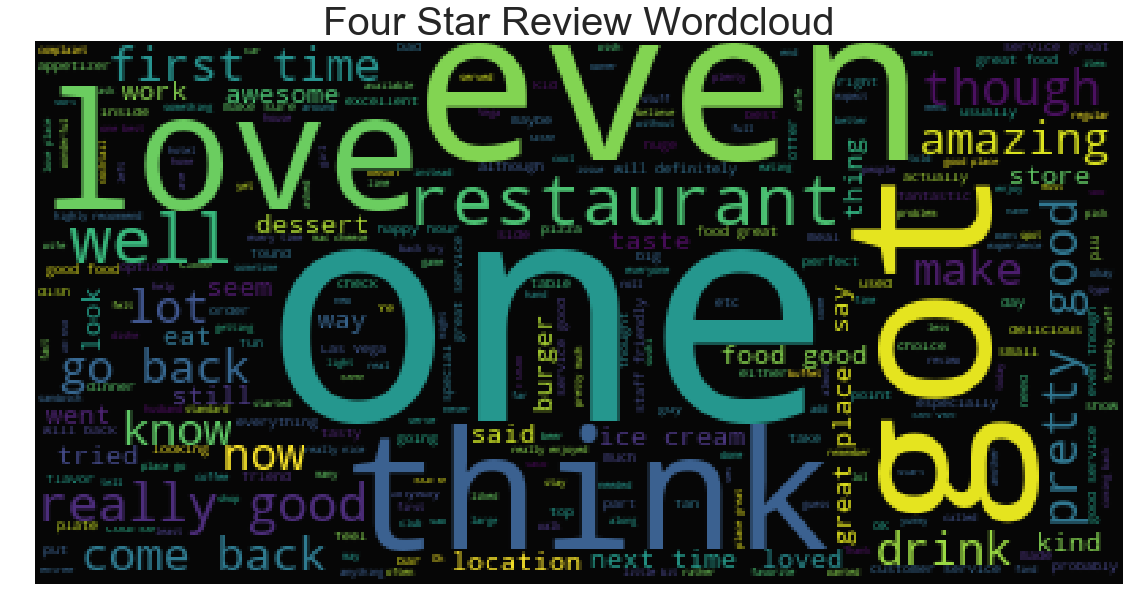

In [516]:
clean_mask = np.array(Image.open('Yelp.png'))
clean_mask = clean_mask[:,:,1]

text = four_star['text'].values

wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Four Star Review Wordcloud", fontsize=40)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

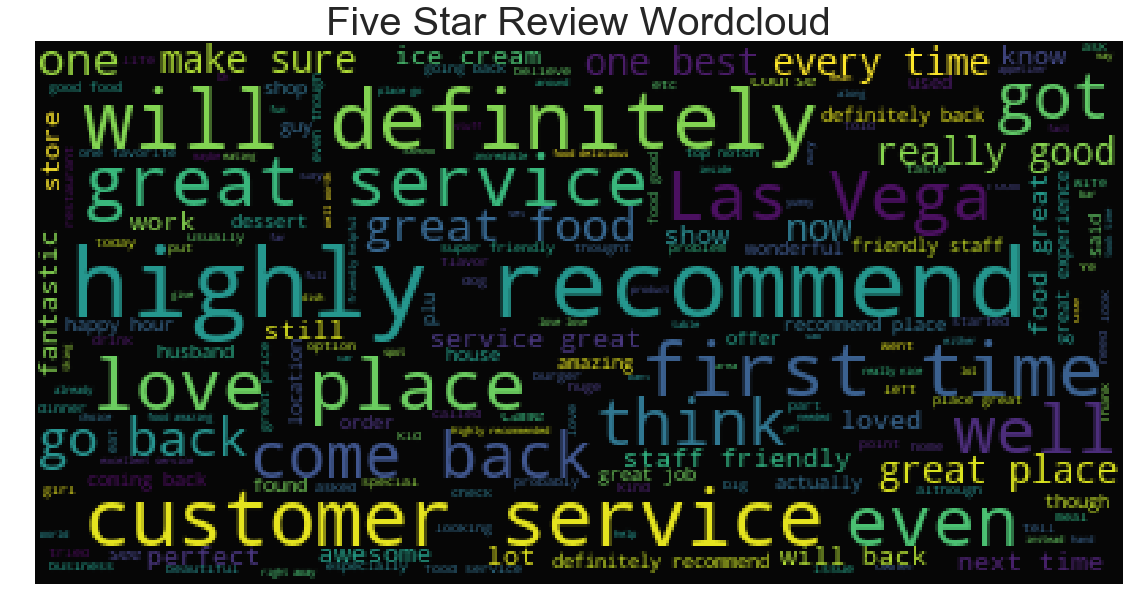

In [517]:
clean_mask = np.array(Image.open('Yelp.png'))
clean_mask = clean_mask[:,:,1]

text = five_star['text'].values

wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Five Star Review Wordcloud", fontsize=40)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

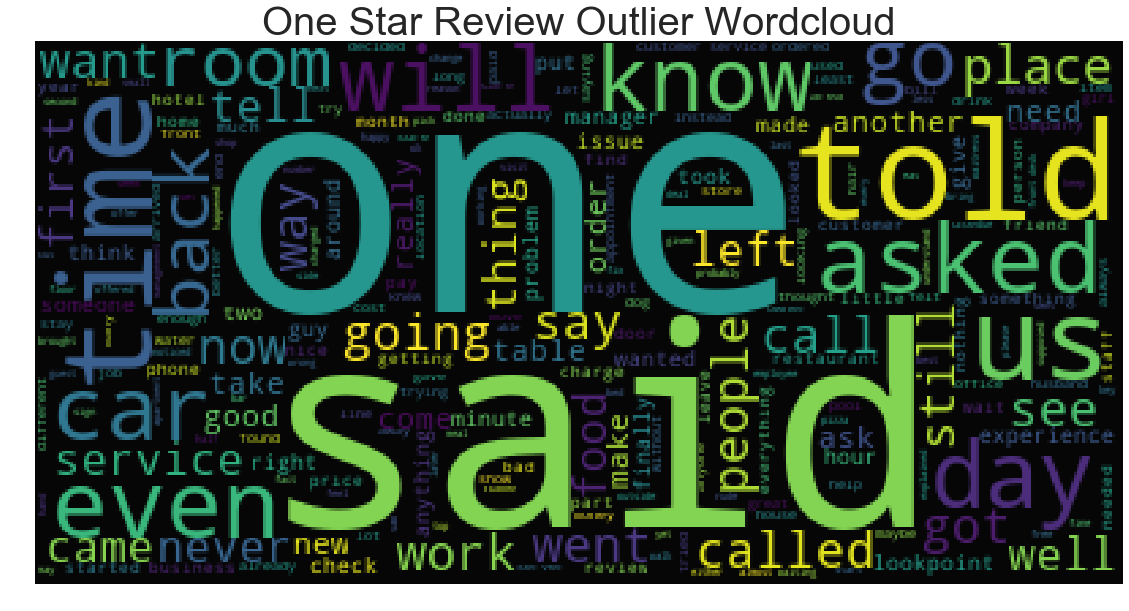

In [561]:
clean_mask = np.array(Image.open('Yelp.png'))
clean_mask = clean_mask[:,:,1]

text = outlier_one_star['text'].values

wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("One Star Review Outlier Wordcloud", fontsize=40)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

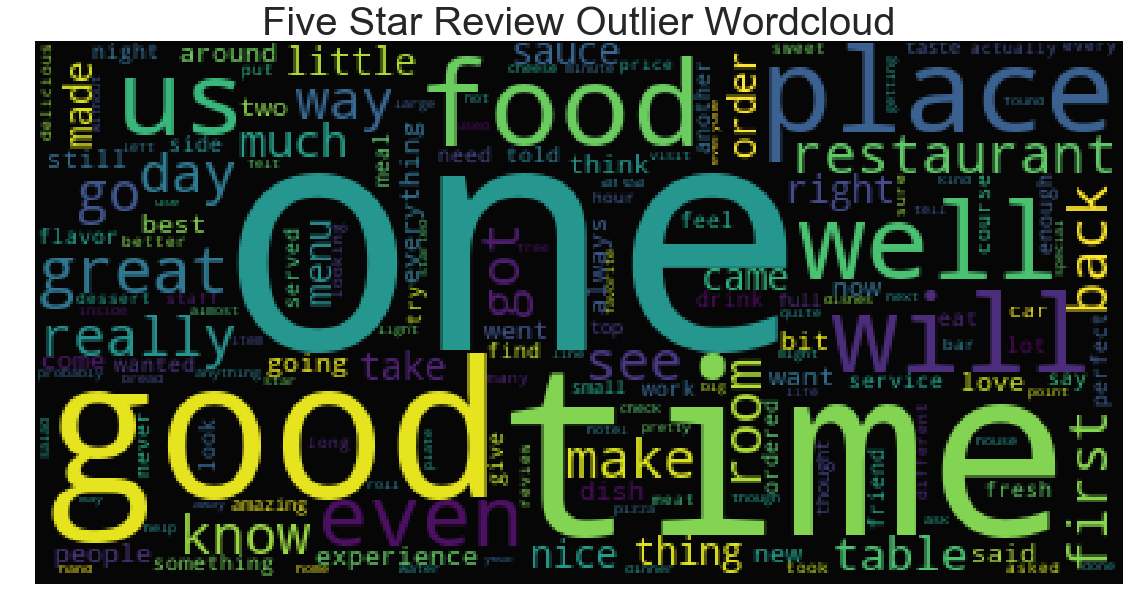

In [562]:
clean_mask = np.array(Image.open('Yelp.png'))
clean_mask = clean_mask[:,:,1]

text = outlier_five_star['text'].values

wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Five Star Review Outlier Wordcloud", fontsize=40)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

<h2>Specific Word Usage</h2>

In [610]:
word_choice = input('Enter the word you want to check use frequency for: ')

one_star_df = one_star[one_star['text'].str.count(word_choice) > 0].reset_index()
print('\nThe word %s showed up %d times in all one star reviews' % (word_choice, len(one_star_df)))

two_star_df = two_star[two_star['text'].str.count(word_choice) > 0].reset_index()
print('\nThe word %s showed up %d times in all two star reviews' % (word_choice, len(two_star_df)))

three_star_df = three_star[three_star['text'].str.count(word_choice) > 0].reset_index()
print('\nThe word %s showed up %d times in all three star reviews' % (word_choice, len(three_star_df)))

four_star_df = four_star[four_star['text'].str.count(word_choice) > 0].reset_index()
print('\nThe word %s showed up %d times in all four star reviews' % (word_choice, len(four_star_df)))

five_star_df = five_star[five_star['text'].str.count(word_choice) > 0].reset_index()
print('\nThe word %s showed up %d times in all five star reviews' % (word_choice, len(five_star_df)))

if len(one_star_df > 0):
    print('\n==RANDOM ONE STAR REVIEW WORD USAGE==')
    print(one_star_df['text'][random.randint(1,len(one_star_df))])

if len(one_star_df > 0):
    print('\n==RANDOM TWO STAR REVIEW WORD USAGE==')
    print(two_star_df['text'][random.randint(1,len(two_star_df))])

if len(one_star_df > 0):
    print('\n==RANDOM THREE STAR REVIEW WORD USAGE==')
    print(three_star_df['text'][random.randint(1,len(three_star_df))])

if len(one_star_df > 0):
    print('\n==RANDOM FOUR STAR REVIEW WORD USAGE==')
    print(four_star_df['text'][random.randint(1,len(four_star_df))])

if len(one_star_df > 0):
    print('\n==RANDOM FIVE STAR REVIEW WORD USAGE==')
    print(five_star_df['text'][random.randint(1,len(five_star_df))])

Enter the word you want to check use frequency for: tasteless

The word tasteless showed up 1299 times in all one star reviews

The word tasteless showed up 1051 times in all two star reviews

The word tasteless showed up 491 times in all three star reviews

The word tasteless showed up 182 times in all four star reviews

The word tasteless showed up 77 times in all five star reviews

==RANDOM ONE STAR REVIEW WORD USAGE==
Where do I begin?  Food is more expensive than most fast food places.  All 3 times I visited,staff would start sweeping, kicking up nasty floor dust that one knows drifts into tour food & lungs.  Asked them to stop.  So, the proceeded to mop floor with disinfectant, which makes food unappetizing.  Any manager knows that if they are not an idiot.  there's are idiots.  Ordered "Fish & Chips" and it came with Mexican "taco chips"!!!  Are Mexican-American restaurant owners that stupid not to know "Fish & Chips" and a British food and "Chips" mean "POTATOES'...like FRENCH 

<h2>Individual User Review Content</h2>

<p>Here we're gonna try to get all of the reviewers who have a large amount of reviews and see if they're generally positive or negative. If they're clear outliers then we can go into discussion of whether or not they're bots, but in general I just want to see if people doing more reviews is generally correlated with giving more negative or more positive reviews.</p>

<p>First thing we'll do is to take the amount of occurrences for each user in the dataframe. This will let us know which user_id's are associated with the most reviews on Yelp.</p>

In [633]:
#df['user_id'].head(20)
review_counts = df['user_id'].value_counts()
reviewers = review_counts.index.tolist()

print(top_ten_reviewers)

ELcQDlf69kb-ihJfxZyL0A    1101
dIIKEfOgo0KqUfGQvGikPg     989
n86B7IkbU20AkxlFX_5aew     955
YMgZqBUAddmFErxLtCfK_w     823
Wu0yySWcHQ5tZ_59HNiamg     761
gwIqbXEXijQNgdESVc07hg     722
hZfzVrhsCQ9JDAb2jYoJNQ     596
CqkdpG2tkCPQA69umlAHsA     534
YwaKGmRNnSa3R3N4Hf9jLw     518
Name: user_id, dtype: int64


<p>Alright, so even in the first 10 reviewers there's a massive spread in  the amount of reviews written. Let's take the top reviewer and see what kind of reviews he's writing.</p>

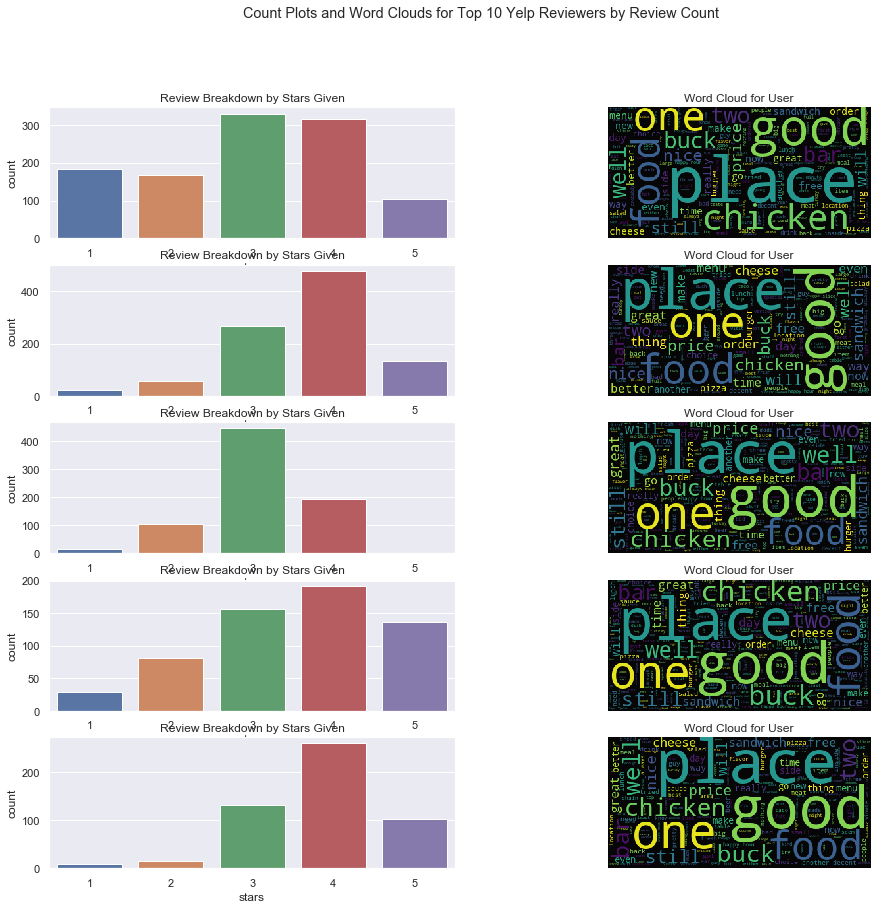

In [651]:
fig, ax = plt.subplots(5,2,figsize=(16,14))
fig.suptitle('Count Plots and Word Clouds for Top 10 Yelp Reviewers by Review Count')

for i in range(0,10,2):
    reviewer_df = df[df['user_id'] == reviewers[i]]
    
    plt.subplot(5,2,i+1)
    sns.countplot(reviewer_df['stars']).set_title('Review Breakdown by Stars Given')
    
    plt.subplot(5,2,i+2)
    text = reviewer_set['text']
    
    wc= WordCloud(background_color="black",max_words=2000)
    wc.generate(" ".join(text))
    plt.axis("off")
    plt.title("Word Cloud for User", fontsize=12)
    plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)